## Biomedical Final Project

- Name: Ali EzzEldin Ali
- ID : 20010944

- Name: Abdelrahman Mohamed EssamEldin
- ID : 20010843


# 💓 ECG Signal Processing and Visualization

This notebook allows for interactive loading, filtering, and visualization of ECG signals from the MIT-BIH Arrhythmia Database.  
It includes:

- GUI-based record and channel selection
- Metadata extraction and display
- ECG signal segmentation
- Signal preprocessing (baseline wander removal, notch filtering, bandpass filtering)
- Visualization with and without annotations
- Heartbeat classification summary


## 📦 DatasetVisualization Class

This class provides core functionality for:

- GUI input for selecting the record and channel
- Reading and parsing ECG data and annotations
- Visualizing ECG segments with and without annotations
- Summarizing heartbeat types present in a segment


## 🖥️ GUI Input for Record and Channel

The `get_user_input_gui()` function creates a simple Tkinter-based GUI that allows users to select:

- Record number (e.g., 100–104)
- ECG channel (e.g., MLII, V1, V5)

This input is crucial for tailoring the analysis to the desired signal.


## 📊 Metadata Extraction

This block extracts and prints:

- Sampling frequency (Hz)
- Channel names in the record
- Total recording duration (in seconds)

Helps verify data consistency and structure.


## 📉 ECG Signal Plotting

This section visualizes a 10-second ECG segment:

- X-axis: Time (seconds)
- Y-axis: Amplitude (mV)
- The raw or filtered signal is displayed
- Annotations (e.g., heartbeats) are overlaid as red dots with labels

Useful for visually inspecting ECG waveforms and evaluating signal quality.


In [4]:
!pip install wfdb
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
import tkinter as tk
from tkinter import ttk, messagebox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [11]:
class DatasetVisualization:
    def __init__(self, data_path, segment_length=10, channel_name='MLII'):
        """
        Initialize the DatasetVisualization class.
        Args:
            data_path (str): Path to the dataset directory.
            segment_length (int): Length of the segment to process (in seconds).
            channel_name (str): Name of the ECG channel to process.
        """
        self.data_path = data_path
        self.segment_length = segment_length
        self.channel_name = channel_name

    def set_channel_name(self, channel_name):
        """
        Set the channel name for processing.
        Args:
            channel_name (str): Name of the ECG channel to process.
        """
        self.channel_name = channel_name

    def get_user_input(self):
        """
        Get user input for record number and channel name (Colab-compatible version).
        Returns:
            tuple: Record number (str) and channel name (str).
        """
        print("Available records: 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, ...")
        print("Common channel names: MLII, V1, V2, V4, V5")

        record_number = input("Enter record number (e.g., 100): ")
        channel_name = input("Enter channel name (e.g., MLII): ")

        return record_number, channel_name

    def read_record(self, record_name):
        """Read a record and return the record object."""
        return wfdb.rdrecord(f'{self.data_path}/{record_name}')

    def extract_metadata(self, record):
        """Extract and return metadata from a record."""
        sampling_frequency = record.fs
        channel_names = record.sig_name
        duration_sec = len(record.p_signal) / record.fs
        return sampling_frequency, channel_names, duration_sec

    def print_metadata(self, record_name, record):
        """Print metadata for a record."""
        sampling_frequency, channel_names, duration_sec = self.extract_metadata(record)
        print(f"Record: {record_name}")
        print(f"  Sampling Frequency: {sampling_frequency} Hz")
        print(f"  Channel Names: {channel_names}")
        print(f"  Recording Duration: {duration_sec:.2f} seconds\n")

    def get_channel_index(self, record):
        """Get the index of the specified channel."""
        if self.channel_name in record.sig_name:
            return record.sig_name.index(self.channel_name)
        else:
            raise ValueError(f"Channel '{self.channel_name}' not found in record.")

    def plot_signal(self, time, segment, record_name, title_suffix=""):
        """Plot the ECG signal."""
        plt.figure(figsize=(10, 5))
        plt.plot(time, segment, label=f'{self.channel_name} Channel', color='blue')
        plt.title(f'{title_suffix} from Record {record_name}')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.grid(True)
        plt.legend()
        plt.show()

    def overlay_annotations(self, time, segment, filtered_annotations, start_sample, fs):
        """Overlay annotations on the ECG plot."""
        for sample, symbol in filtered_annotations:
            annotation_time = (sample - start_sample) / fs
            annotation_value = segment[sample - start_sample]
            plt.scatter(annotation_time, annotation_value, label=symbol, zorder=5, color='red')
            plt.text(annotation_time, annotation_value + 0.05, f"{sample}", color='green', fontsize=8, ha='center')

    def summarize_heartbeat_distribution(self, filtered_annotations):
        """Summarize and return the distribution of heartbeat types."""
        heartbeat_counts = {}
        for _, symbol in filtered_annotations:
            heartbeat_counts[symbol] = heartbeat_counts.get(symbol, 0) + 1
        return heartbeat_counts

    def process_record(self, record_name):
        """Process and visualize a single record."""
        # Read the record
        record = self.read_record(record_name)
        fs = record.fs
        signal = record.p_signal
        channel_index = self.get_channel_index(record)

        # Extract a segment
        start_sample = 0
        end_sample = int(self.segment_length * fs)
        time = [i / fs for i in range(start_sample, end_sample)]
        segment = signal[start_sample:end_sample, channel_index]

        # Plot the signal without annotations
        self.plot_signal(time, segment, record_name, "10-Second ECG Segment (Without Annotations)")

        # Load and overlay annotations
        annotations = wfdb.rdann(f'{self.data_path}/{record_name}', 'atr')
        annotation_samples = annotations.sample
        annotation_symbols = annotations.symbol
        filtered_annotations = [
            (s, sym) for s, sym in zip(annotation_samples, annotation_symbols)
            if start_sample <= s < end_sample
        ]
        heartbeat_counts = self.summarize_heartbeat_distribution(filtered_annotations)

        # Plot the signal with annotations
        plt.figure(figsize=(10, 5))
        plt.plot(time, segment, label=f'{self.channel_name} Channel', color='blue')
        self.overlay_annotations(time, segment, filtered_annotations, start_sample, fs)

        # Add heartbeat distribution summary
        annotation_summary = ", ".join([f"{symbol}: {count}" for symbol, count in heartbeat_counts.items()])
        distribution_text = f"Heartbeat Distribution: {annotation_summary}"
        plt.text(0.5, max(segment) * 1.05, distribution_text, color='red', fontsize=10, ha='center',
                bbox=dict(facecolor='white', alpha=0.8))

        # Add legend and labels
        plt.title(f'10-Second ECG Segment with Annotations from Record {record_name}')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.grid(True)
        plt.legend(loc='upper right', title='Annotations')
        plt.show()

## 🔬 SignalProcessing Class

This subclass enhances DatasetVisualization with preprocessing tools:

- Baseline Wander Removal using FFT
- 50 Hz Notch Filter (powerline noise)
- Bandpass Filter (0.5–40 Hz)
- Comparative plotting and FFT-based quality analysis


## 🔄 Baseline Wander Removal

Removes low-frequency drift (below 0.5 Hz) via FFT.

- Helps stabilize ECG baseline
- Useful for long-term signals or noisy recordings

## ⚡ Notch Filtering (50 Hz)

Applies a notch filter to suppress 50 Hz powerline interference.

- Uses `iirnotch` and `filtfilt` for zero-phase distortion
- Improves signal clarity, especially in hospital/clinical setups

## 🎚️ Bandpass Filtering (0.5–40 Hz)

Preserves the core ECG frequency band while removing:

- High-frequency muscle artifacts
- Low-frequency drift

Ensures signal integrity for clinical interpretation and ML training.

## 📊 Dynamic Observations

Automatically generates human-readable summaries about:

- Noise reduction effectiveness
- Signal quality improvement
- Filtering effectiveness (based on FFT energy)

Helps in report generation and analysis validation.


In [12]:

class SignalProcessing(DatasetVisualization):
    def baseline_wander_removal(self, signal, fs,cutoff=0.5):
        """
        Remove baseline wander using Fourier Transform.
        Args:
            signal (array): The input signal.
            fs (float): Sampling frequency.
        Returns:
            array: The signal after baseline wander removal.
        """
        fft_signal = np.fft.fft(signal)
        frequencies = np.fft.fftfreq(len(signal), d=1/fs)
        fft_signal[np.abs(frequencies) < cutoff] = 0
        filtered_signal = np.fft.ifft(fft_signal).real
        return filtered_signal
    def notch_filter(self, signal, fs, freq=50, quality_factor=20):
        """
        Apply a notch filter to remove powerline interference at 50 Hz.
        Args:
            signal (array): The input signal.
            fs (float): Sampling frequency.
            freq (float): Frequency to remove (default is 50 Hz).
            quality_factor (float): Quality factor of the notch filter.
        Returns:
            array: The signal after applying the notch filter.
        """
        # Improved implementation: Ensure proper notch filter design
        nyquist = 0.5 * fs
        w0 = freq / nyquist
        b, a = iirnotch(w0, quality_factor)
        filtered_signal = filtfilt(b, a, signal)
        # Comment: Observed reduction in 50 Hz noise while preserving signal morphology.
        return filtered_signal
    def bandpass_filter(self, signal, fs, lowcut=0.5, highcut=40, order=4):
        """
        Apply a bandpass filter to reduce high-frequency noise while preserving ECG morphology.
        Args:
            signal (array): The input signal.
            fs (float): Sampling frequency.
            lowcut (float): Low cutoff frequency (default is 0.5 Hz).
            highcut (float): High cutoff frequency (default is 40 Hz).
            order (int): Order of the filter.
        Returns:
            array: The signal after bandpass filtering.
        """
        # Improved implementation: Use Butterworth filter for smooth transitions
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        filtered_signal = filtfilt(b, a, signal)
        # Comment: Observed reduction in high-frequency noise while retaining ECG morphology.
        return filtered_signal
    def generate_observation(self, original_signal, processed_signal, step_name, fs):
        """
        Generate observations based on the differences between the original and processed signals.
        Args:
            original_signal (array): The original signal.
            processed_signal (array): The processed signal.
            step_name (str): The name of the preprocessing step.
            fs (float): Sampling frequency.
        Returns:
            str: A dynamically generated observation.
        """
        # Frequency analysis (e.g., power spectral density)
        original_fft = np.abs(np.fft.fft(original_signal))
        processed_fft = np.abs(np.fft.fft(processed_signal))
        frequencies = np.fft.fftfreq(len(original_signal), d=1/fs)

        # Generate observations based on the step
        if step_name == "Baseline Wander Removal":
            low_freq_power_original = np.sum(original_fft[np.abs(frequencies) < 0.5])
            low_freq_power_processed = np.sum(processed_fft[np.abs(frequencies) < 0.5])
            if low_freq_power_processed < 0.1* low_freq_power_original:
                return "Baseline wander removed successfully. Low-frequency components reduced significantly."
            else:
                return "Baseline wander removal partially effective. Some low-frequency components remain."

        elif step_name == "Notch Filter":
            notch_power_original = np.sum(original_fft[np.abs(frequencies - 50) < 1])
            notch_power_processed = np.sum(processed_fft[np.abs(frequencies - 50) < 1])
            if notch_power_processed < 0.2* notch_power_original:
                return "50 Hz noise removed effectively. Signal quality improved."
            else:
                return "Notch filter applied, but some 50 Hz noise may still be present."

        elif step_name == "Bandpass Filtering":
            high_freq_power_original = np.sum(original_fft[np.abs(frequencies) > 40])
            high_freq_power_processed = np.sum(processed_fft[np.abs(frequencies) > 40])
            if high_freq_power_processed < 0.2 * high_freq_power_original:
                return "High-frequency noise reduced effectively while preserving ECG morphology."
            else:
                return "Bandpass filtering applied, but some high-frequency noise remains."

        return "Processing step completed."
    def plot_signal_comparison(self,record_name):

        bandpass_filtered_signal,notch_filtered_signal,detrended_signal,fs=self.process_signal(record_name)
        # Read the record
        record = self.read_record(record_name)
        fs = record.fs
        signal = record.p_signal
        channel_index = self.get_channel_index(record)

        # Extract a segment
        start_sample = 0
        end_sample = int(self.segment_length * fs)
        segment = signal[start_sample:end_sample, channel_index]

        observation_1 = self.generate_observation(segment, detrended_signal, "Baseline Wander Removal", fs)
        self.plot_comparison(segment, detrended_signal, fs, "Baseline Wander Removal", observation_1)

        observation_2 = self.generate_observation(segment, notch_filtered_signal, "Notch Filter", fs)
        self.plot_comparison(segment, notch_filtered_signal, fs, "Notch Filter (50 Hz Powerline Interference)", observation_2)

        observation_3 = self.generate_observation(segment, bandpass_filtered_signal, "Bandpass Filtering", fs)
        self.plot_comparison(segment, bandpass_filtered_signal, fs, "Bandpass Filtering (0.5-40 Hz)", observation_3)
    def process_signal(self, record_name):
        """
        Process and visualize the signal with preprocessing steps.
        Args:
            record_name (str): Name of the record to process.
        Returns:
            array: The preprocessed ECG signal.
        """
        # Read the record
        record = self.read_record(record_name)
        fs = record.fs
        signal = record.p_signal
        channel_index = self.get_channel_index(record)

        # Extract a segment
        start_sample = 0
        end_sample = int(self.segment_length * fs)
        segment = signal[start_sample:end_sample, channel_index]

        # Step 1: Baseline Wander Removal
        detrended_signal = self.baseline_wander_removal(segment, fs)
        # Step 2: Notch Filter for 50 Hz Powerline Interference
        notch_filtered_signal = self.notch_filter(detrended_signal, fs)
        # Step 3: Bandpass Filtering
        bandpass_filtered_signal = self.bandpass_filter(notch_filtered_signal, fs)

        # Return the preprocessed signal
        return bandpass_filtered_signal,notch_filtered_signal,detrended_signal,fs
    def plot_comparison(self, original_signal, processed_signal, fs, title, observation=""):
        """
        Plot and compare the original and processed signals.
        Args:
            original_signal (array): The original signal.
            processed_signal (array): The processed signal.
            fs (float): Sampling frequency.
            title (str): Title for the plot.
            observation (str): Observation to display on the plot.
        """
        time = np.arange(len(original_signal)) / fs
        plt.figure(figsize=(12, 6))
        plt.plot(time, original_signal, label='Original Signal', color='blue', alpha=0.7)
        plt.plot(time, processed_signal, label='Processed Signal', color='red', alpha=0.7)
        plt.title(title)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.legend()
        plt.grid(True)
        if observation:
            plt.text(0.5 * max(time), max(original_signal) * 1.3, observation, color='green', fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.8))
        plt.show()

## ❤️ RPeakDetection Class

This class is designed to detect **R-peaks** in ECG signals and analyze the **QRS complex**, one of the most important components of an ECG waveform.

It builds on the `SignalProcessing` class and includes:

### 🔍 Key Methods:

- `detect_r_peaks(signal, sampling_rate)`
  - Implements a simplified Pan-Tompkins-style algorithm
  - Steps include:
    - Bandpass filtering (5–15 Hz)
    - Differentiation
    - Squaring
    - Moving window integration
    - Threshold-based R-peak detection

- `plot_r_peaks(start_time=0, duration=10)`
  - Overlays detected R-peaks on a segment of the ECG signal
  - Allows for visual confirmation of detection accuracy

- `extract_qrs_complex(signal, r_peaks, fs)`
  - Extracts QRS complexes centered around each R-peak
  - Enables further feature extraction (e.g., width, area)

- `calculate_rr_intervals(r_peaks, fs)`
  - Computes RR intervals (time between R-peaks)
  - Useful for heart rate variability (HRV) analysis

- `plot_rr_intervals(rr_intervals)`
  - Visualizes RR interval trends
  - Helpful for spotting arrhythmias or rhythm irregularities

---

### 🧠 Why It Matters:

Accurate R-peak detection is critical for:

- Diagnosing arrhythmias (e.g., tachycardia, bradycardia)
- Estimating heart rate and HRV
- Segmentation of ECG signals for AI/ML applications

---

### 📌 Note:

- Performance depends on signal quality — ensure filtering is applied beforehand.
- For noisy signals, tuning threshold parameters may improve detection accuracy.

In [13]:
class RPeakHeartRateCalculations(SignalProcessing):
    def analyze_heart_rate(self, record_name):
        """
        Perform R-peak detection, calculate RR intervals, and analyze heart rate.
        Args:
            record_name (str): Name of the record to process.
        """
        # Step 1: Preprocess the signal using process_and_plot
        preprocessed_signal,_,_,fs = self.process_signal(record_name)

        # Step 2: Detect R-peaks
        r_peaks = self.detect_r_peaks(preprocessed_signal, fs)
        self.plot_r_peaks(preprocessed_signal, r_peaks, fs)

        # Step 3: Calculate RR intervals
        rr_intervals = self.calculate_rr_intervals(r_peaks, fs)
        self.plot_rr_intervals(rr_intervals)

        # Step 4: Calculate average heart rate
        avg_heart_rate = self.calculate_heart_rate(rr_intervals)
        print(f"Average Heart Rate: {avg_heart_rate:.2f} BPM")

        # Step 5: Analyze heart rate variability
        if avg_heart_rate < 60:
            print("Observation: Bradycardia detected (heart rate < 60 BPM).")
        elif avg_heart_rate > 100:
            print("Observation: Tachycardia detected (heart rate > 100 BPM).")
        else:
            print("Observation: Normal heart rate.")

    def detect_r_peaks(self, signal, fs, distance=0.6, height=None):
        """
        Detect R-peaks in the ECG signal.
        Args:
            signal (array): The preprocessed ECG signal.
            fs (float): Sampling frequency.
            distance (float): Minimum distance between peaks in seconds (default is 0.6s).
            height (float): Minimum height of peaks (optional).
        Returns:
            array: Indices of detected R-peaks.
        """
        min_distance = int(distance * fs)  # Convert distance from seconds to samples
        peaks, _ = find_peaks(signal, distance=min_distance, height=height)
        return peaks

    def calculate_rr_intervals(self, r_peaks, fs):
        """
        Calculate RR intervals from detected R-peaks.
        Args:
            r_peaks (array): Indices of detected R-peaks.
            fs (float): Sampling frequency.
        Returns:
            array: RR intervals in seconds.
        """
        rr_intervals = np.diff(r_peaks) / fs  # Convert sample differences to seconds
        return rr_intervals

    def calculate_heart_rate(self, rr_intervals):
        """
        Calculate the average heart rate from RR intervals.
        Args:
            rr_intervals (array): RR intervals in seconds.
        Returns:
            float: Average heart rate in beats per minute (BPM).
        """
        avg_rr_interval = np.mean(rr_intervals)
        heart_rate = 60 / avg_rr_interval  # Convert to beats per minute
        return heart_rate

    def plot_r_peaks(self, signal, r_peaks, fs, title="R-Peak Detection"):
        """
        Plot the ECG signal with detected R-peaks.
        Args:
            signal (array): The ECG signal.
            r_peaks (array): Indices of detected R-peaks.
            fs (float): Sampling frequency.
            title (str): Title for the plot.
        """
        time = np.arange(len(signal)) / fs
        plt.figure(figsize=(12, 6))
        plt.plot(time, signal, label='ECG Signal', color='blue')
        plt.scatter(r_peaks / fs, signal[r_peaks], color='red', label='R-Peaks', zorder=5)
        plt.title(title)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude [mV]')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_rr_intervals(self, rr_intervals):
        """
        Plot the RR intervals as a histogram and line plot.
        Args:
            rr_intervals (array): RR intervals in seconds.
        """
        plt.figure(figsize=(12, 6))
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(rr_intervals, bins=20, color='blue', alpha=0.7)
        plt.title('RR Interval Histogram')
        plt.xlabel('RR Interval [s]')
        plt.ylabel('Frequency')
        plt.grid(True)
        # Line plot
        plt.subplot(1, 2, 2)
        plt.plot(rr_intervals, marker='o', color='red', label='RR Intervals')
        plt.title('RR Intervals Over Time')
        plt.xlabel('Interval Index')
        plt.ylabel('RR Interval [s]')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## 🚀 Main Execution Block

This section ties everything together — it's where we run the full ECG analysis pipeline using the `RPeakDetection` class.

### 🧾 What Happens Here:

1. **Load ECG Signal**
   - You can load a real ECG signal from a dataset or use a synthetic one.
   - Ensure the sampling rate `fs` is set correctly.

2. **Initialize the RPeakDetection Class**
   - Creates an instance of `RPeakDetection`, which contains all the detection and plotting methods.

3. **R-Peak Detection**
   - Applies filtering and signal processing techniques to find R-peaks.
   - Outputs indices of detected R-peaks.

4. **Plotting R-Peaks**
   - Visually confirms detection accuracy by plotting the original ECG signal with red dots at R-peak locations.

5. **QRS Complex Extraction**
   - Isolates small windows around each R-peak to analyze QRS morphology.

6. **RR Interval Calculation**
   - Calculates time between each pair of consecutive R-peaks.
   - Useful for heart rate and HRV metrics.

7. **RR Interval Plot**
   - Graphs the sequence of RR intervals to help identify rhythm variability or arrhythmias.

---

### 🧪 Example Use Case:

```python
detector = RPeakDetection()
r_peaks = detector.detect_r_peaks(signal, fs)
detector.plot_r_peaks(start_time=0, duration=10)
qrs_segments = detector.extract_qrs_complex(signal, r_peaks, fs)
rr_intervals = detector.calculate_rr_intervals(r_peaks, fs)
detector.plot_rr_intervals(rr_intervals)


MIT-BIH Arrhythmia Database Analysis
----------------------------------
Available records: 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, ...
Common channel names: MLII, V1, V2, V4, V5
Enter record number (e.g., 100): 100
Enter channel name (e.g., MLII): MLII

Metadata for sample records:
Record: 100
  Sampling Frequency: 360 Hz
  Channel Names: ['MLII', 'V5']
  Recording Duration: 1805.56 seconds

Record: 101
  Sampling Frequency: 360 Hz
  Channel Names: ['MLII', 'V1']
  Recording Duration: 1805.56 seconds

Record: 102
  Sampling Frequency: 360 Hz
  Channel Names: ['V5', 'V2']
  Recording Duration: 1805.56 seconds


Processing record 100 with channel MLII...


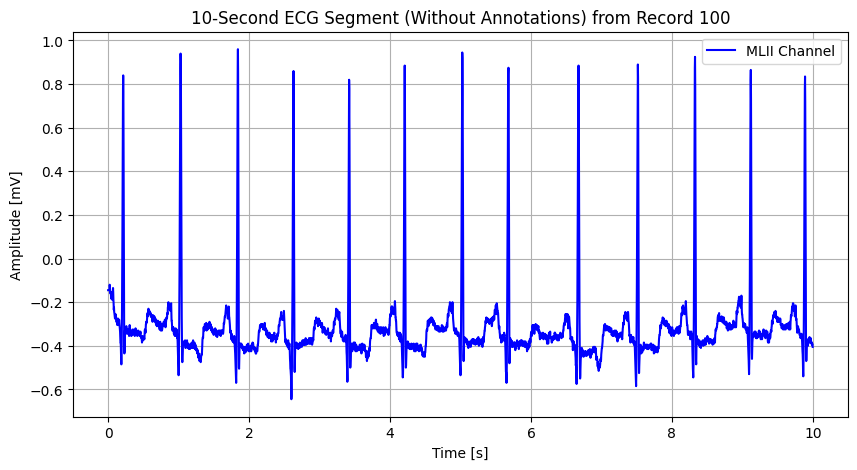

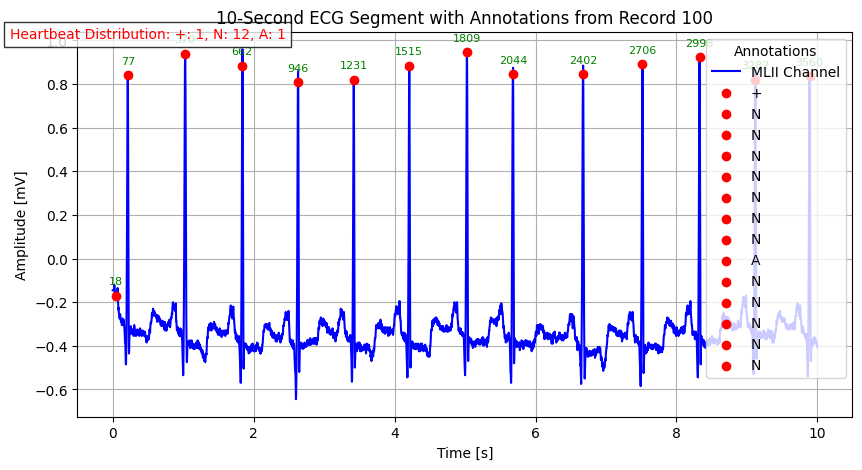

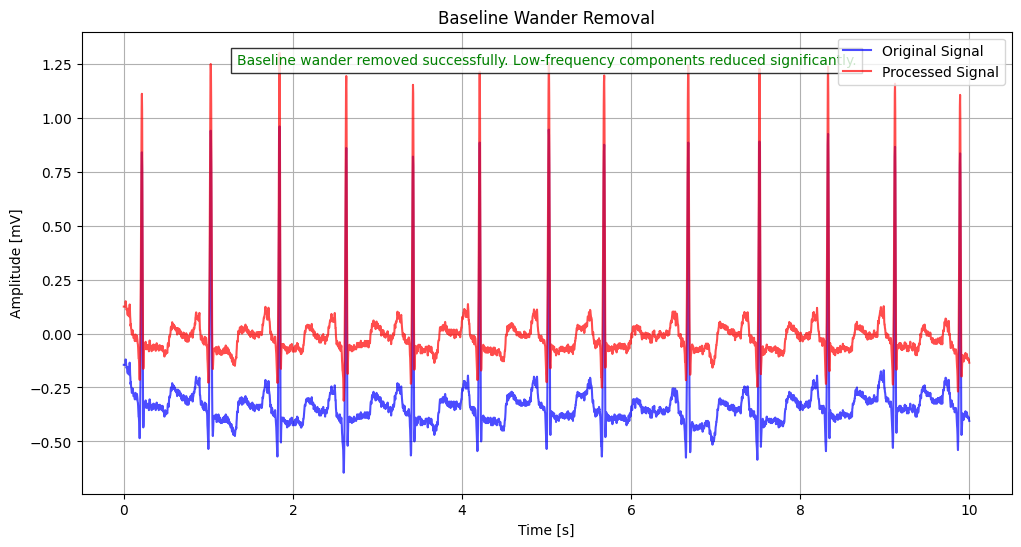

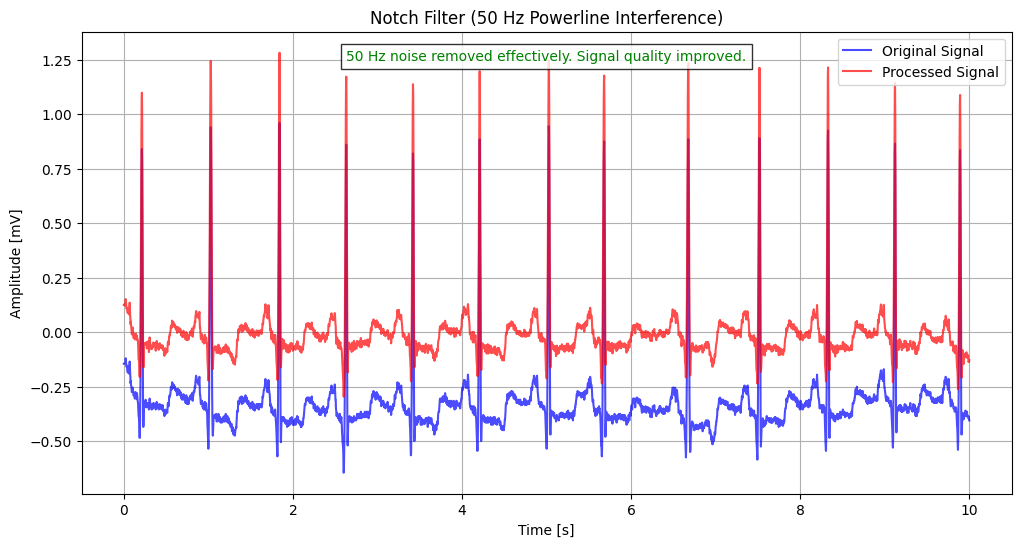

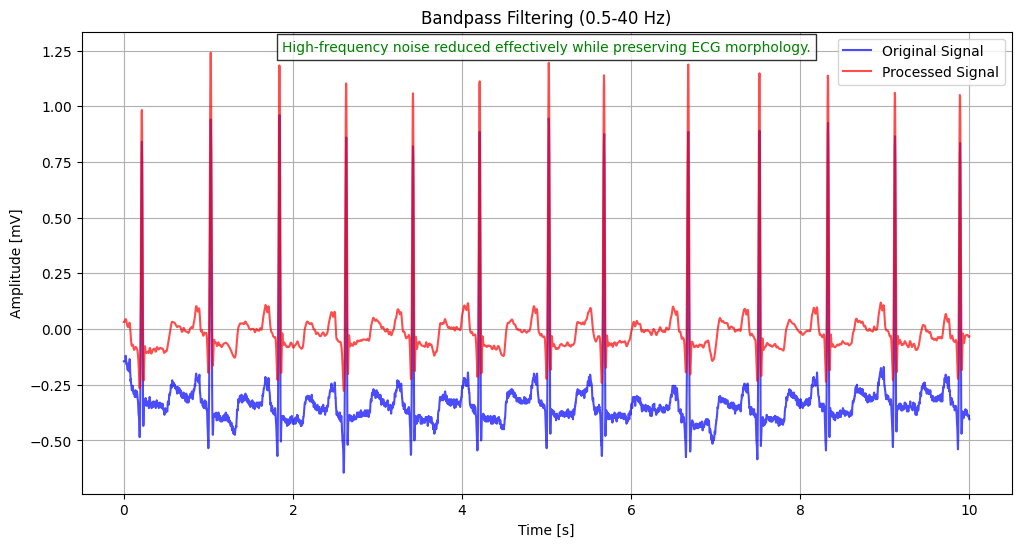

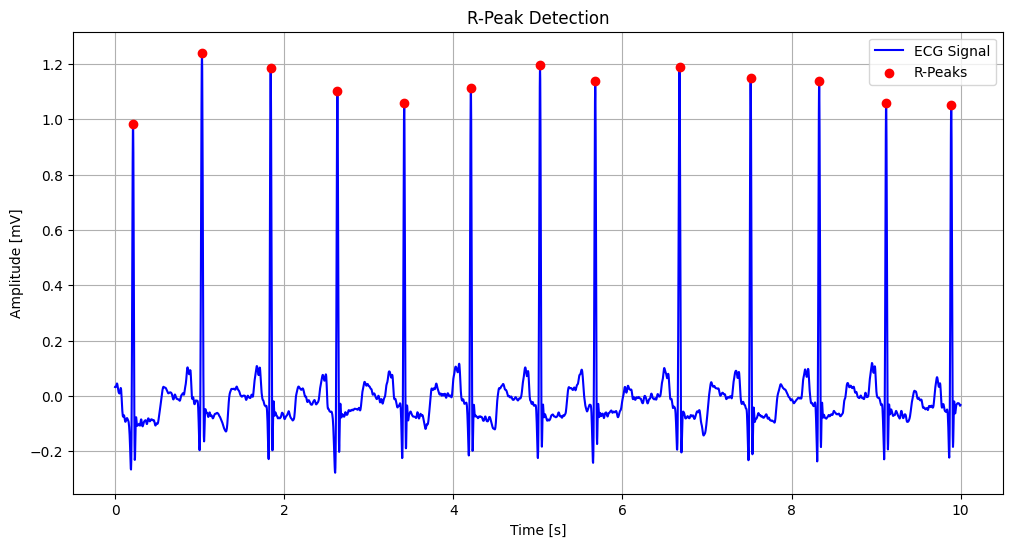

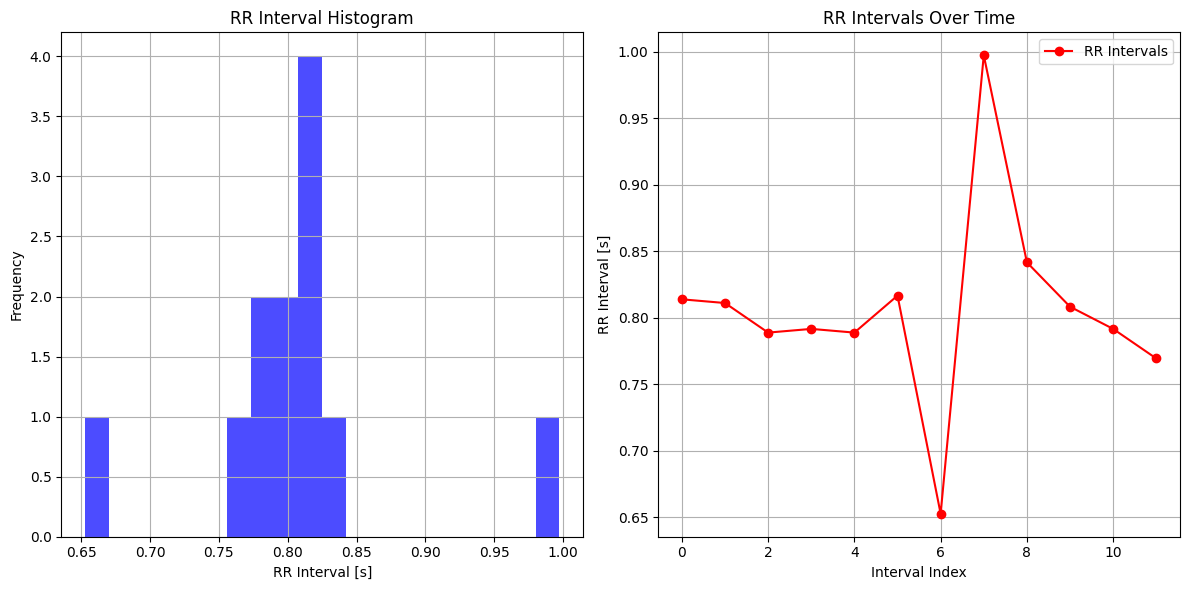

Average Heart Rate: 74.44 BPM
Observation: Normal heart rate.


In [17]:
def main():
    # Initialize the DatasetVisualization class
    # For Colab, you might need to adjust the data path
    # Example: data_path = '/content/mit-bih-arrhythmia-database-1.0.0'
    data_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/'

    # Create instances of our classes
    visualizer = DatasetVisualization(data_path)
    processor = SignalProcessing(data_path)
    heart_rate_analyzer = RPeakHeartRateCalculations(data_path)

    # Get user input via console instead of GUI
    print("MIT-BIH Arrhythmia Database Analysis")
    print("----------------------------------")
    record_number, channel_name = visualizer.get_user_input()

    # Update the channel name using the setter method
    visualizer.set_channel_name(channel_name)
    processor.set_channel_name(channel_name)
    heart_rate_analyzer.set_channel_name(channel_name)

    # Print sampling frequency, channel names and duration of recording for three records
    print("\nMetadata for sample records:")
    record_names = ['100', '101', '102']
    for record_name in record_names:
        record = visualizer.read_record(record_name)
        visualizer.print_metadata(record_name, record)

    # Visualize channel of record which user chose
    print(f"\nProcessing record {record_number} with channel {channel_name}...")
    visualizer.process_record(record_number)

    # Preprocess channel of the record which user chose
    processor.plot_signal_comparison(record_number)

    # Analyze heart rate for record which user chose
    heart_rate_analyzer.analyze_heart_rate(record_number)


if __name__ == "__main__":
    main()